<a href="https://colab.research.google.com/github/1bensupriatma/GenerativeAI/blob/main/HW3/Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ben Supriatma
Generative AI
10/11
Assignment 3

Task 1

In [3]:

!wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
!wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics,
)
import numpy as np
from scipy.io import loadmat

from scipy.stats import norm
#Allows for change for different testing
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 500

# Load data
train_data = loadmat('train_32x32.mat')
test_data = loadmat('test_32x32.mat')

# Preprocess data: normalize and reshape
x_train = np.transpose(train_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_train = train_data['y'].flatten()
x_test = np.transpose(test_data['X'], (3, 0, 1, 2)).astype('float32') / 255.0
y_test = test_data['y'].flatten()

# Display dataset shape
print(f'Training data shape: {x_train.shape}')
print(f'Test data shape: {x_test.shape}')

--2024-10-12 07:57:19--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  30.9MB/s    in 5.5s    

2024-10-12 07:57:24 (31.7 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2024-10-12 07:57:24--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  49.1MB/s    in 1.2s    

2024-10-12 07:57:25 (49.1 MB/s) - ‘test_32x32.mat’ saved [64275384/64

Task 2
-Build encoder and decoder, construct VAE that is able to take differing latent space

In [4]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
#ENCODER
latent_dim = EMBEDDING_DIM
encoder_input = layers.Input(shape=(32, 32, 3), name="encoder_input") # Changed input shape to (32, 32, 3)
x = layers.Conv2D(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(encoder_input)
x = layers.Conv2D(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2D(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x) # Use the defined latent_dim
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 32)     │            896 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 8, 8, 64)       │         18,496 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 4, 4, 128)      │         73,856 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 2048)           │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │          4,098 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 101,444 (396.27 KB)

 Trainable params: 101,444 (396.27 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
#DECODER

decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    128, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    64, (3, 3), strides=2, activation="relu", padding="same"
)(x)
x = layers.Conv2DTranspose(
    32, (3, 3), strides=2, activation="relu", padding="same"
)(x)

decoder_output = layers.Conv2D(
    3,
    (3, 3),
    strides=1,
    activation="sigmoid",
    padding="same",
    name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │           6,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 16, 16, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Conv2D)              │ (None, 32, 32, 3)           │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 246,851 (964.26 KB)

 Trainable params: 246,851 (964.26 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.binary_crossentropy(data, reconstruction, axis=(1, 2, 3)))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [8]:
def build_vae(latent_dim):
    vae = VAE(encoder, decoder)
    return vae

vae_model = build_vae(EMBEDDING_DIM)
vae_model.compile(optimizer='adam')

Task 3- Training the VAE with different latent dimensions

In [11]:
latent_dims = [2, 5, 10]
for dim in latent_dims:
    print(f'Training VAE with latent dimension: {dim}')
    vae = build_vae(latent_dim=dim)
    vae.compile(optimizer='adam', loss=losses.binary_crossentropy)
    vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

Training VAE with latent dimension: 2
Epoch 1/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - kl_loss: 1.7557 - reconstruction_loss: 328.6695 - total_loss: 330.4252 - val_kl_loss: 2.9046 - val_loss: 316.2290 - val_reconstruction_loss: 313.3244
Epoch 2/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - kl_loss: 2.7718 - reconstruction_loss: 318.4488 - total_loss: 321.2205 - val_kl_loss: 3.1025 - val_loss: 317.0041 - val_reconstruction_loss: 313.9016
Epoch 3/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 2.8070 - reconstruction_loss: 318.0890 - total_loss: 320.8960 - val_kl_loss: 2.9636 - val_loss: 316.4560 - val_reconstruction_loss: 313.4924
Epoch 4/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - kl_loss: 2.8195 - reconstruction_loss: 318.0464 - total_loss: 320.8659 - val_kl_loss: 2.9161 - val_loss: 316.6525 - val_reconstruction_loss: 313.7364
Epoch 5/50
573/573 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - kl_loss: 2.8275 - reconstruction_loss: 318.1963 - total_loss: 321.0238 - val_kl_loss

Task 4- Create Visualizations

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Examples


array([[[[0.14901961, 0.40392157, 0.23529412],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16470589, 0.40392157, 0.24313726],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.23921569],
         [0.15294118, 0.40784314, 0.24313726],
         ...,
         [0.16078432, 0.4       , 0.23921569],
         [0.16862746, 0.39607844, 0.24705882],
         [0.15294118, 0.38039216, 0.22352941]],

        [[0.14901961, 0.4117647 , 0.24313726],
         [0.14509805, 0.40784314, 0.23921569],
         [0.15294118, 0.41568628, 0.24705882],
         ...,
         [0.16862746, 0.39607844, 0.24705882],
         [0.16862746, 0.39215687, 0.2509804 ],
         [0.15294118, 0.38039216, 0.23137255]],

        ...,

        [[0.20392157, 0.46666667, 0.30588236],
         [0.20784314, 0.47058824, 0.30980393]

Reconstructions


array([[[[0.29965734, 0.28062207, 0.2661008 ],
         [0.30183506, 0.2825482 , 0.26358455],
         [0.30446824, 0.28333622, 0.2647703 ],
         ...,
         [0.28080782, 0.2622391 , 0.250928  ],
         [0.2731942 , 0.2562058 , 0.24684492],
         [0.2735259 , 0.256162  , 0.24834737]],

        [[0.29643127, 0.278354  , 0.26296628],
         [0.29593328, 0.27772117, 0.26194215],
         [0.300667  , 0.27929798, 0.26158613],
         ...,
         [0.27666166, 0.25709063, 0.24543181],
         [0.27183008, 0.25401387, 0.24322696],
         [0.2714124 , 0.25430346, 0.24720159]],

        [[0.29819286, 0.2798188 , 0.26368368],
         [0.2953851 , 0.27790594, 0.26626924],
         [0.29823998, 0.27841732, 0.26549667],
         ...,
         [0.2720613 , 0.25594968, 0.24317281],
         [0.26849765, 0.24904785, 0.2378983 ],
         [0.269662  , 0.25225657, 0.247928  ]],

        ...,

        [[0.3008658 , 0.28603095, 0.27370834],
         [0.30347306, 0.2866282 , 0.27310508]

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[ 1.3516442   0.3422139 ]
 [-0.96413517 -0.6028085 ]
 [-1.0001873   0.11257686]
 [-0.89071494  0.8599849 ]
 [-1.1622832   0.939663  ]
 [ 0.21337397 -0.6646679 ]
 [ 2.862604    1.7501614 ]
 [ 1.0264913   3.1131182 ]
 [-0.9103575  -0.6549764 ]
 [-0.75779206  0.05094346]]


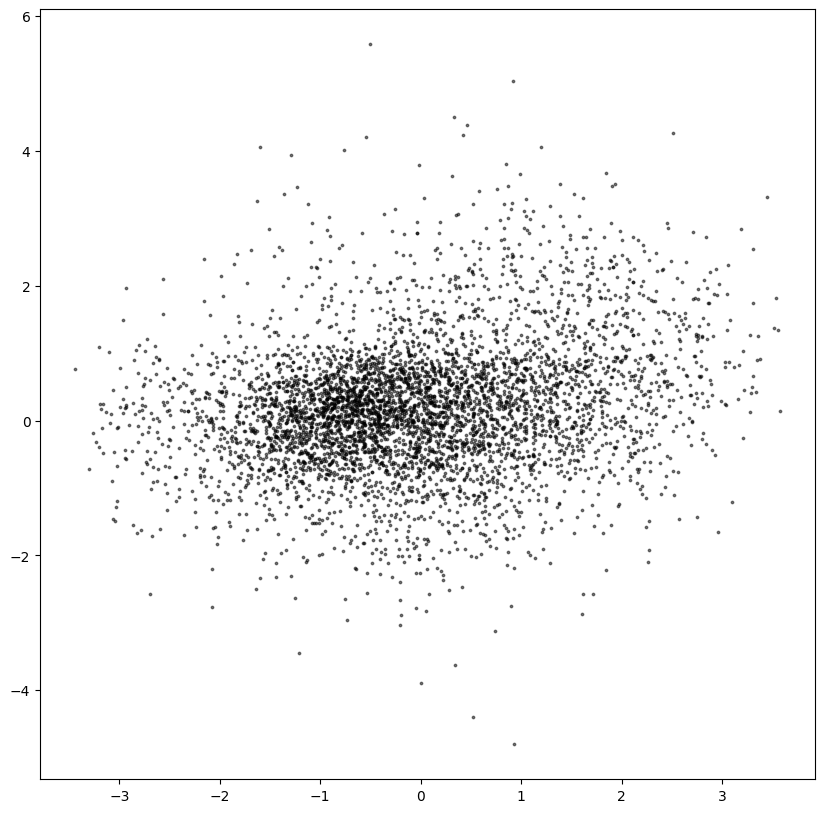

In [18]:
predicts = 5000
images = x_test[:predicts]
labels = y_test[:predicts]
z_mean, z_log_var, reconstructions = vae.predict(images)
print("Examples")
display(images)
print("Reconstructions")
display(reconstructions)

z_mean, z_var, z = encoder.predict(images)
print(z[:10])

figsize = 10

plt.figure(figsize=(figsize, figsize))
plt.scatter(z[:, 0], z[:, 1], c="black", alpha=0.5, s=3)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


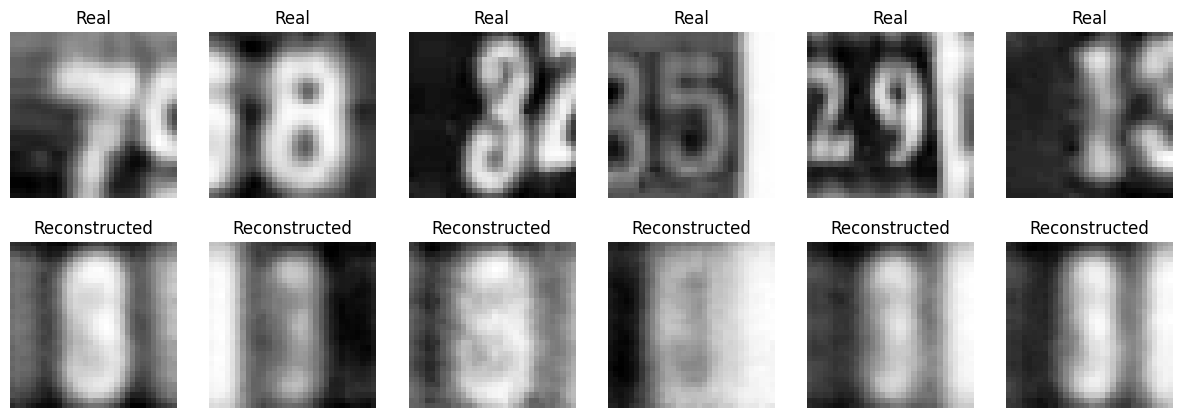

In [35]:
from scipy.stats import norm
grid_width, grid_height = (6, 3)

# Step 1: Select random real examples from the test set
random_idx = np.random.choice(x_test.shape[0], 6, replace=False)
real_images = x_test[random_idx]

# Step 2: Encode and decode the real images using the VAE
_, _, z_real = encoder.predict(real_images)
reconstructed_images = decoder.predict(z_real)

# Step 3: Plot real and reconstructed images side by side
fig, axes = plt.subplots(2, 6, figsize=(15, 5))

for i in range(6):
    axes[0, i].imshow(real_images[i, :, :, 0], cmap="Greys")
    axes[0, i].axis("off")
    axes[0, i].set_title("Real")

# Plot reconstructed images in the second row
for i in range(6):
    axes[1, i].imshow(reconstructed_images[i, :, :, 0], cmap="Greys")
    axes[1, i].axis("off")
    axes[1, i].set_title("Reconstructed")


DISCUSSION

Compare the original and reconstructed images from the SVHN dataset, you should display two rows of images:

Original Images: The original images are pixelated, but it is still legible to the eye. For example in the third example the real clearly reads a 3

Reconstructed Images: With the reconstructed picture below, we can only tell that the numbers are similar looking at the original image next to it.

What you need to discuss:
Clarity: The numbers recreated are sort of clear, but some are still pixalted

Distortion: The distortion may be due to the high reconstruction loss. I think that with more time, I could train the model.

Variability: The background in most of these reconstructions are very similar to the original, but the numbers are still distorted.

Generalization: I think the VAE is successfully learning because it is making its own numbers that are a little bit legible. With more training the model will be much better.